# A Variational Autoencoder for generating pictures of cats

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,\
                         Conv2DTranspose, Flatten, Reshape, Lambda, ELU, BatchNormalization, Activation 
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
import keras.backend as kb
from src.vaeHelpers import *

%matplotlib inline

Using TensorFlow backend.


## Load the data

Load the data, create a training/validation split. Save the split to a file to help with continuation of training.

In [2]:
trainFresh = False

if ( trainFresh ):
    catFiles = np.array( glob('./catCroped/*.jpg') )
    #catFiles = np.array( glob('/home/baxter/Desktop/MLbook/DogClassifier/trainCrop/*.jpg') )
    
    valFrac = 0.1
    n = len(catFiles)
    
    inds = np.random.permutation( len(catFiles) )
    trainInds, valInds = inds[ : -int(n*valFrac) ], inds[ -int(n*valFrac) : ]
    
    train, val = catFiles[ trainInds ], catFiles[ valInds ]
    
    writeFilesList( "trainFiles.txt", train )
    writeFilesList( "valFiles.txt", val )

else:
    val   = readSavedFiles( "valFiles.txt" )
    train = readSavedFiles( "trainFiles.txt" )

## Set some parameters

In [3]:
batchSize = 16
codeSize  = 2048
imgSize   = 256
filters   = 64

colour = 3

factor = imgSize * imgSize

## Define the model

In [4]:
inputs = Input( shape = ( imgSize, imgSize, colour,) )

conv1 = Conv2D( filters, 3, strides = 1, padding = 'same', use_bias = None, data_format = "channels_last")( inputs )
bn1   = ELU()(BatchNormalization()(conv1))
pool1 = MaxPooling2D( data_format = "channels_last" )( bn1 )

conv2 = Conv2D( filters//2, 3, strides = 1, padding = 'same', use_bias = None, data_format = "channels_last" )( pool1 )
bn2   = ELU()(BatchNormalization()(conv2))
pool2 = MaxPooling2D( data_format = "channels_last" )( bn2 )

conv3 = Conv2D( filters//4, 3, strides = 1, padding = 'same', use_bias = None, data_format = "channels_last" )( pool2 )
bn3   = ELU()(BatchNormalization()(conv3))
pool3 = MaxPooling2D( data_format = "channels_last" )( bn3 )

conv4 = Conv2D( filters//8, 3, strides = 1, padding = 'same', data_format = "channels_last" )( pool3 )
bn4   = ELU()(BatchNormalization()(conv4))
pool4 = MaxPooling2D( data_format = "channels_last" )( bn4 )

flat  = Flatten()( pool4 )

dense1 = Dense( codeSize, use_bias = False )( flat )
bnd1 = ELU()(BatchNormalization()(dense1))

mean     = Dense( codeSize )( bnd1 )
logSigma = Dense( codeSize )( bnd1 )

encoding = Lambda(sampling, output_shape = ( codeSize,) )( [mean, logSigma] )

decoderInput = Input( shape = (codeSize, ) )

dense2 = Dense( codeSize, use_bias = False )( decoderInput ) #6
bnd2 = ELU()(BatchNormalization()(dense2))

dense3 = Dense( (filters//8) * 16 * 16, use_bias = False )( bnd2 )
bn6   = ELU()(BatchNormalization()(dense3))

unflatten = Reshape( (16, 16, filters//8) )(bn6 ) #6

unpool2 = UpSampling2D( data_format = "channels_last" )( unflatten )
deconv2 = Conv2DTranspose( filters//4, 3, strides = 1, padding = 'same', data_format = "channels_last" )( unpool2 )
bn8     = ELU()(BatchNormalization()( deconv2 ))

unpool3 = UpSampling2D( data_format = "channels_last" )( bn8 )
deconv3 = Conv2DTranspose( filters//2, 3, strides = 1, padding = 'same', use_bias = None, data_format = "channels_last" )( unpool3 )
bn9     = ELU()(BatchNormalization()( deconv3 ))

unpool4 = UpSampling2D( data_format = "channels_last" )( bn9 )
deconv4 = Conv2DTranspose( filters, 3, strides = 1, padding = 'same', use_bias = None, data_format = "channels_last" )( unpool4 )
bn10    = ELU()(BatchNormalization()( deconv4 ))

unpool5  = UpSampling2D( data_format = "channels_last" )( bn10 )
decoding = Conv2DTranspose( colour, 3, strides = 1, padding = 'same', data_format = "channels_last", activation = "sigmoid" )( unpool5 )

In [5]:
encoder = Model( inputs, [mean, logSigma, encoding], name = 'encoder')
decoder = Model( decoderInput, decoding, name = "decoder")

fullPass = decoder( encoder(inputs)[2] )

VAE = Model( inputs, fullPass, name = 'vae' )

In [6]:
#reconLoss = factor * binary_crossentropy( kb.flatten( inputs ), kb.flatten( fullPass ) )
reconLoss = factor * mse( kb.flatten( inputs ), kb.flatten( fullPass ) )
klLoss = -0.5 * kb.sum(1 + logSigma - kb.square(mean) - kb.exp(logSigma), axis = -1 )
loss = kb.mean( reconLoss + klLoss )

opt = Adam() #Adam( lr = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1.0, decay = 0.1 )

VAE.add_loss( loss )
VAE.compile( optimizer = opt, loss = None )

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if __name__ == '__main__':


In [7]:
VAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
encoder (Model)              [(None, 2048), (None, 204 12621608  
_________________________________________________________________
decoder (Model)              (None, 256, 256, 3)       8431379   
Total params: 21,052,987
Trainable params: 21,040,235
Non-trainable params: 12,752
_________________________________________________________________


## Train the model

In [8]:
if ( not trainFresh ):
    VAE.load_weights( "weights/catGen.hdf5" )

earlyStopper = EarlyStopping( patience = 50, verbose = 1 )
checkPointer = ModelCheckpoint( filepath = "weights/catGen.hdf5", save_best_only = True, verbose = 1 )
rateReduce   = ReduceLROnPlateau( monitor = 'val_loss', factor = 0.5, patience = 20, cooldown = 5 )

losses = VAE.fit_generator( genBatch( train, batchSize, imgSize, True ),
                   validation_data = genBatch( val, batchSize, imgSize, False ),
                   epochs = 5000,
                   validation_steps = len(val)   // batchSize,
                   steps_per_epoch  = len(train) // batchSize,
                   callbacks = [ earlyStopper, checkPointer ] )
                   #callbacks = [ earlyStopper, checkPointer, rateReduce ] )

Epoch 1/5000
558/559 [============================>.] - ETA: 0s - loss: 1506.7415
Epoch 00001: val_loss improved from inf to 1391.72343, saving model to weights/catGen.hdf5
559/559 [==============================] - 140s 250ms/step - loss: 1506.7086 - val_loss: 1391.7234
Epoch 2/5000
558/559 [============================>.] - ETA: 0s - loss: 1508.0652
Epoch 00002: val_loss did not improve
559/559 [==============================] - 138s 247ms/step - loss: 1508.0278 - val_loss: 1395.0752
Epoch 3/5000
558/559 [============================>.] - ETA: 0s - loss: 1501.0886
Epoch 00003: val_loss improved from 1391.72343 to 1387.25585, saving model to weights/catGen.hdf5
559/559 [==============================] - 138s 247ms/step - loss: 1500.6580 - val_loss: 1387.2559
Epoch 4/5000
558/559 [============================>.] - ETA: 0s - loss: 1498.4299
Epoch 00004: val_loss improved from 1387.25585 to 1373.05547, saving model to weights/catGen.hdf5
559/559 [==============================] - 138s 24

Epoch 36/5000
558/559 [============================>.] - ETA: 0s - loss: 1444.8505
Epoch 00036: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1444.5753 - val_loss: 1343.1321
Epoch 37/5000
558/559 [============================>.] - ETA: 0s - loss: 1440.6418
Epoch 00037: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1441.0317 - val_loss: 1373.9170
Epoch 38/5000
558/559 [============================>.] - ETA: 0s - loss: 1455.1606
Epoch 00038: val_loss did not improve
559/559 [==============================] - 138s 246ms/step - loss: 1454.8796 - val_loss: 1365.6333
Epoch 39/5000
558/559 [============================>.] - ETA: 0s - loss: 1448.6802
Epoch 00039: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1448.6220 - val_loss: 1371.8869
Epoch 40/5000
558/559 [============================>.] - ETA: 0s - loss: 1433.3475
Epoch 00040: val_loss did not improve

558/559 [============================>.] - ETA: 0s - loss: 1416.5980
Epoch 00072: val_loss did not improve
559/559 [==============================] - 138s 246ms/step - loss: 1416.9165 - val_loss: 1467.7367
Epoch 73/5000
558/559 [============================>.] - ETA: 0s - loss: 1414.5063
Epoch 00073: val_loss did not improve
559/559 [==============================] - 137s 245ms/step - loss: 1414.8045 - val_loss: 1374.7314
Epoch 74/5000
558/559 [============================>.] - ETA: 0s - loss: 1402.3161
Epoch 00074: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1402.3767 - val_loss: 1304.8507
Epoch 75/5000
558/559 [============================>.] - ETA: 0s - loss: 1404.1140
Epoch 00075: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1403.7116 - val_loss: 1308.2680
Epoch 76/5000
558/559 [============================>.] - ETA: 0s - loss: 1405.7405
Epoch 00076: val_loss did not improve
559/559 [====

Epoch 109/5000
558/559 [============================>.] - ETA: 0s - loss: 1378.7656
Epoch 00109: val_loss improved from 1269.51189 to 1268.76285, saving model to weights/catGen.hdf5
559/559 [==============================] - 138s 246ms/step - loss: 1378.6232 - val_loss: 1268.7628
Epoch 110/5000
558/559 [============================>.] - ETA: 0s - loss: 1378.1471
Epoch 00110: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1378.0311 - val_loss: 1340.5212
Epoch 111/5000
558/559 [============================>.] - ETA: 0s - loss: 1382.5882
Epoch 00111: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1382.8638 - val_loss: 1270.8542
Epoch 112/5000
558/559 [============================>.] - ETA: 0s - loss: 1366.1831
Epoch 00112: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1366.1621 - val_loss: 1424.0249
Epoch 113/5000
558/559 [============================>.] 

Epoch 145/5000
558/559 [============================>.] - ETA: 0s - loss: 1354.3762
Epoch 00145: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1354.6394 - val_loss: 1258.3384
Epoch 146/5000
558/559 [============================>.] - ETA: 0s - loss: 1342.1714
Epoch 00146: val_loss did not improve
559/559 [==============================] - 137s 245ms/step - loss: 1342.2225 - val_loss: 1358.8839
Epoch 147/5000
558/559 [============================>.] - ETA: 0s - loss: 1348.1804
Epoch 00147: val_loss did not improve
559/559 [==============================] - 137s 246ms/step - loss: 1348.3596 - val_loss: 1302.9887
Epoch 148/5000
558/559 [============================>.] - ETA: 0s - loss: 1344.8082
Epoch 00148: val_loss improved from 1240.48009 to 1237.11475, saving model to weights/catGen.hdf5
559/559 [==============================] - 138s 246ms/step - loss: 1345.0263 - val_loss: 1237.1148
Epoch 149/5000
558/559 [============================>.] 

Epoch 182/5000
558/559 [============================>.] - ETA: 0s - loss: 1341.8286
Epoch 00182: val_loss did not improve
559/559 [==============================] - 138s 247ms/step - loss: 1342.0726 - val_loss: 1268.7644
Epoch 183/5000
558/559 [============================>.] - ETA: 0s - loss: 1318.2281
Epoch 00183: val_loss did not improve
559/559 [==============================] - 138s 246ms/step - loss: 1318.7260 - val_loss: 1264.3077
Epoch 184/5000
558/559 [============================>.] - ETA: 0s - loss: 1331.6050
Epoch 00184: val_loss did not improve
559/559 [==============================] - 138s 247ms/step - loss: 1331.5305 - val_loss: 1245.9449
Epoch 185/5000
558/559 [============================>.] - ETA: 0s - loss: 1327.9647
Epoch 00185: val_loss did not improve
559/559 [==============================] - 139s 249ms/step - loss: 1328.3303 - val_loss: 1278.4558
Epoch 186/5000
558/559 [============================>.] - ETA: 0s - loss: 1336.6000
Epoch 00186: val_loss did not im

## Plot a learning curve

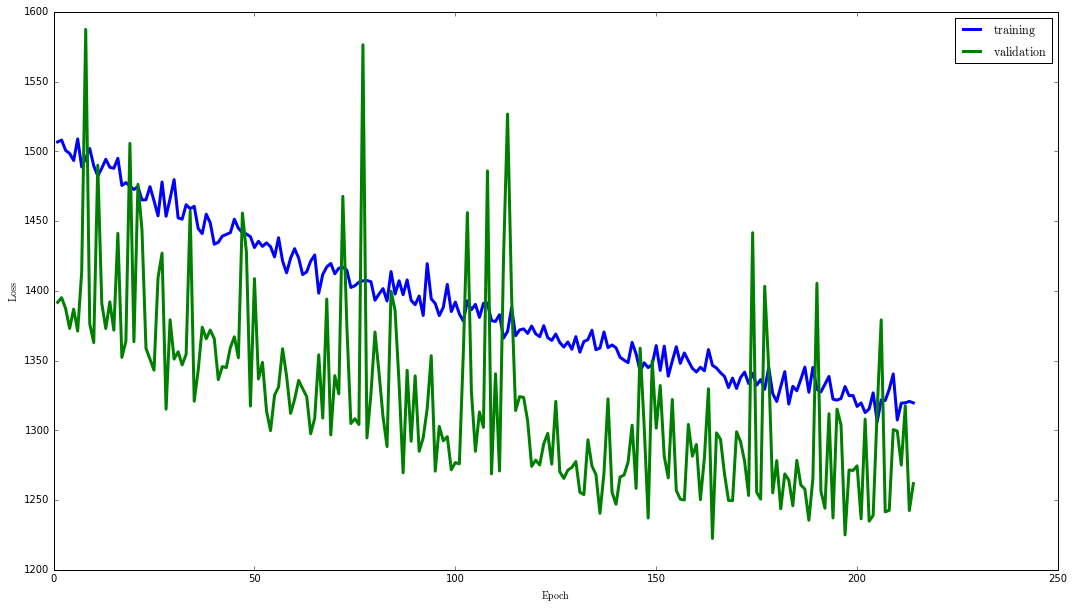

In [9]:
plotLosses( losses.history )

## Test the last training iteration


		Original:


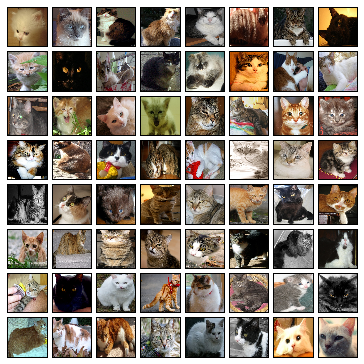


		Reconstruction:


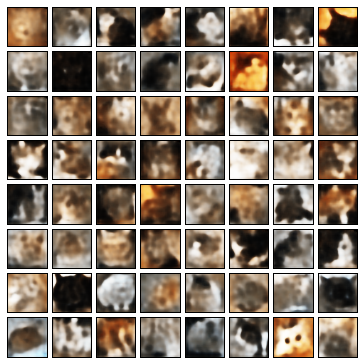

In [10]:
catSample, _ = next( genBatch( val, 64, imgSize = imgSize ) )
recon   = VAE.predict( catSample )

print( "\n\t\tOriginal:" )
plotGrid( catSample, "", (5, 5) )

print( "\n\t\tReconstruction:" )
plotGrid( recon, "", (5, 5) )

		Generated:


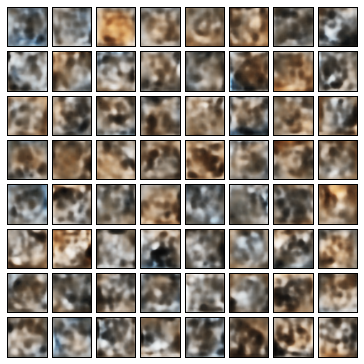

In [11]:
codes = np.random.normal( size = (64, codeSize) )
cats  = decoder.predict( codes )

print( "\t\tGenerated:" )
plotGrid( cats, "", (5, 5) )

In [12]:
VAE.save_weights( "weights/catGen-last.hdf5" )

## Best validation loss

In [13]:
VAE.load_weights( "weights/catGen.hdf5" )

		Generated:


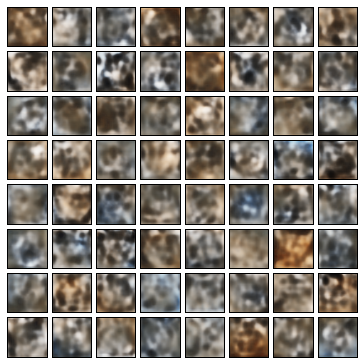

In [18]:
codes = np.random.normal( size = (64, codeSize) )
cats = decoder.predict( codes )

print( "\t\tGenerated:" )
plotGrid( cats, "", (5, 5) )


		Original:


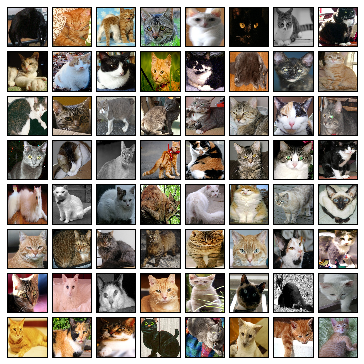


		Reconstruction:


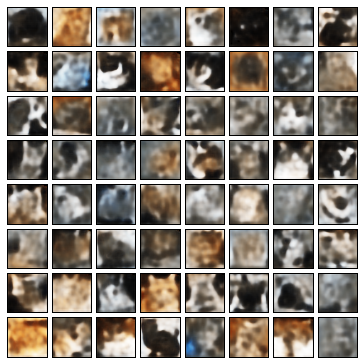

In [19]:
catSample, _ = next( genBatch( val, 64, imgSize, False ) )

recon = VAE.predict( catSample )

print( "\n\t\tOriginal:" )
plotGrid( catSample, "", size = (5, 5) )

print( "\n\t\tReconstruction:" )
plotGrid( recon, "", size = (5, 5) )